# ***Graph Neural Networks for End-to-End Particle Identification with the CMS Experiment***
### *written by Khalid Bagus Pratama Darmadi, S.Si (Khalid); Papua, Indonesia*
*for ML4SCI on Google Summer of Code 2023*

Common Task 1. Electron/photon classification
Datasets:

> https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (photons)
> https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (electrons)


Description: 32x32 matrices (two channels - hit energy and time) for two classes of
particles electrons and photons impinging on a calorimeter

Please use a deep learning method of your choice to achieve the highest possible
classification on this dataset (we ask that you do it both in Keras/Tensorflow and in
PyTorch). Please provide a Jupyter notebook that shows your solution. The model you submit should have a ROC AUC score of at least 0.80.

**Solution:**

For this task, here is the model description for classifying whether the output would be an electron or a photon. The data will be preprocessed with normalization and quantization to 8-bits.

This model combine custom layers and EfficientNetB2 for purpose of effectively learn and classify the features of electrons and photons impinging on a calorimeter. The residual block, channel reduction, and EfficientNetB2 suppose to help the model learn complex features, while the dense layers, dropout, and global average pooling enable it to perform the final classification.

1. Input and concatenation layer

> The input layer accepts a tensor of shape (32, 32, 2), which corresponds to the hit energy and time data. The model then concatenates the input data along the channel axis to create a 3-channel tensor, which is required as input for the EfficientNetB2 model.

2. Residual block layer

> The model incorporates a residual block that consists of two convolutional layers (Conv2D and DepthwiseConv2D) with a GELU (Gaussian Error Linear Unit) activation function, followed by batch normalization layers. The output of the residual block is added back to the original input. This design allows the model to learn complex patterns and feature representations while reducing the risk of vanishing gradients. The GELU activation function improves the model's learning capabilities compared to more traditional activation functions like ReLU.

3. Channel reduction layer

> A 1x1 convolution layer is used to reduce the number of channels in the output tensor of the residual block from 6 to 3. This operation not only reduces the complexity of the model but also allows it to match the input requirements of the EfficientNetB2 model.

4. EfficientNetB2 layer

> This is a state-of-the-art convolutional neural network architecture that has been optimized for better performance and smaller model size. By incorporating EfficientNetB2 into the model, it can effectively learn more complex and abstract features from the input data, leading to better classification performance. The EfficientNetB2 model is pretrained on the ImageNet dataset, which means it already has a good understanding of general features, and this can help in faster convergence and better performance in the specific task of electron/photon classification.


5. Global Average Pooling
> This layer is used to reduce the spatial dimensions of the EfficientNetB2 output. By taking the average value of each feature map, it generates a fixed-length feature vector that can be fed into the subsequent dense layers.


6. Dense layers and Dropout
> The model uses a dense layer with 256 units and a GELU activation function to learn a higher-level representation of the input features. The dropout layer with a rate of 0.5 helps prevent overfitting by randomly setting a fraction of the input units to 0 during training.

7. Output layer

> The final dense layer with one unit and a sigmoid activation function produces a probability value between 0 and 1, representing the likelihood of the input belonging to the positive class (either electron or photon, depending on how the labels are assigned).

In [ ]:
import h5py
import pandas as pd
import numpy as np

electron_file = h5py.File('/content/drive/MyDrive/GSoC/task_1/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5')
photon_file = h5py.File('/content/drive/MyDrive/GSoC/task_1/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5')

print("Keys in electron_file:")
print(list(electron_file.keys()))

print("\nKeys in photon_file:")
print(list(photon_file.keys()))

Keys in electron_file:
['X', 'y']

Keys in photon_file:
['X', 'y']


In [ ]:
# If the files have a nested structure, we can explore it further like this:

print("\nStructure of electron_file:")
def print_structure(name, obj):
    print(f"{name}: {type(obj)}")
    
electron_file.visititems(print_structure)

print("\nStructure of photon_file:")
photon_file.visititems(print_structure)


Structure of electron_file:
X: <class 'h5py._hl.dataset.Dataset'>
y: <class 'h5py._hl.dataset.Dataset'>

Structure of photon_file:
X: <class 'h5py._hl.dataset.Dataset'>
y: <class 'h5py._hl.dataset.Dataset'>


In [ ]:
# Load the data and labels

electron_X = electron_file['X']
electron_y = electron_file['y']
photon_X = photon_file['X']
photon_y = photon_file['y']

In [ ]:
# Inspect the shapes

print("Shapes:")
print(f"Electron data (X): {electron_X.shape}")
print(f"Electron labels (y): {electron_y.shape}")
print(f"Photon data (X): {photon_X.shape}")
print(f"Photon labels (y): {photon_y.shape}")

Shapes:
Electron data (X): (249000, 32, 32, 2)
Electron labels (y): (249000,)
Photon data (X): (249000, 32, 32, 2)
Photon labels (y): (249000,)


In [ ]:
# Print the first few samples and labels

print("\nFirst 5 samples and labels for electrons:")
for i in range(5):
    print(f"Sample {i}:")
    print(electron_X[i])
    print(f"Label {i}: {electron_y[i]}")

print("\nFirst 5 samples and labels for photons:")
for i in range(5):
    print(f"Sample {i}:")
    print(photon_X[i])
    print(f"Label {i}: {photon_y[i]}")


First 5 samples and labels for electrons:
Sample 0:
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 ...

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]]
Label 0: 1.0
Sample 1:
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 ...

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]]
Label 1: 1.0
Sample 2:
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0.

Electron data statistics:
Hit Energy Channel:
  Min: 0.0
  Max: 1.4318130016326904
  Mean: 0.001215839758515358
  Std: 0.022602548822760582

Hit Time Channel:
  Min: -2.512557029724121
  Max: 2.275660276412964
  Mean: -0.0002865783462766558
  Std: 0.06925680488348007

Photon data statistics:
Hit Energy Channel:
  Min: 0.0
  Max: 1.4849443435668945
  Mean: 0.0012234959285706282
  Std: 0.02478918246924877

Hit Time Channel:
  Min: -2.512557029724121
  Max: 2.2779698371887207
  Mean: -0.00023703569604549557
  Std: 0.06545672565698624
Electron data statistics:
Hit Energy Channel:
  Min: 0.0
  Max: 1.4318130016326904
  Mean: 0.001215839758515358
  Std: 0.022602548822760582

Hit Time Channel:
  Min: -2.512557029724121
  Max: 2.275660276412964
  Mean: -0.0002865783462766558
  Std: 0.06925680488348007

Photon data statistics:
Hit Energy Channel:
  Min: 0.0
  Max: 1.4849443435668945
  Mean: 0.0012234959285706282
  Std: 0.02478918246924877

Hit Time Channel:
  Min: -2.512557029724121
  Max: 2.27

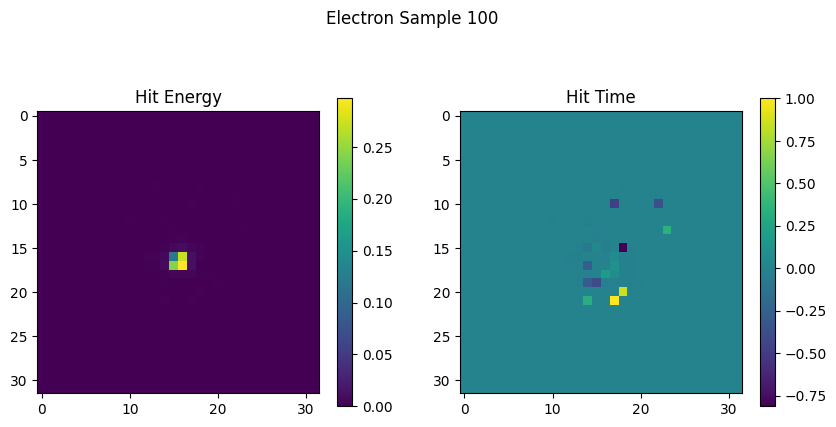

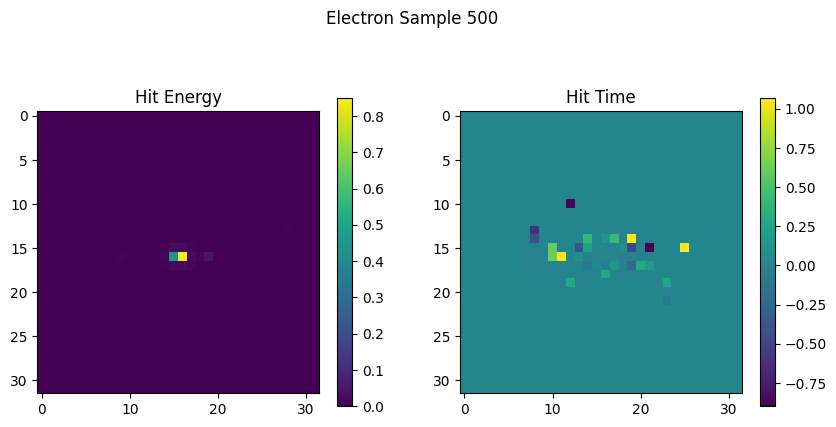

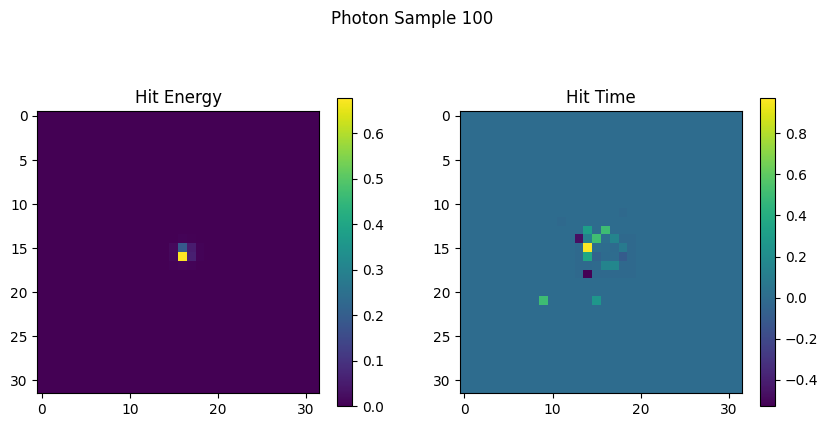

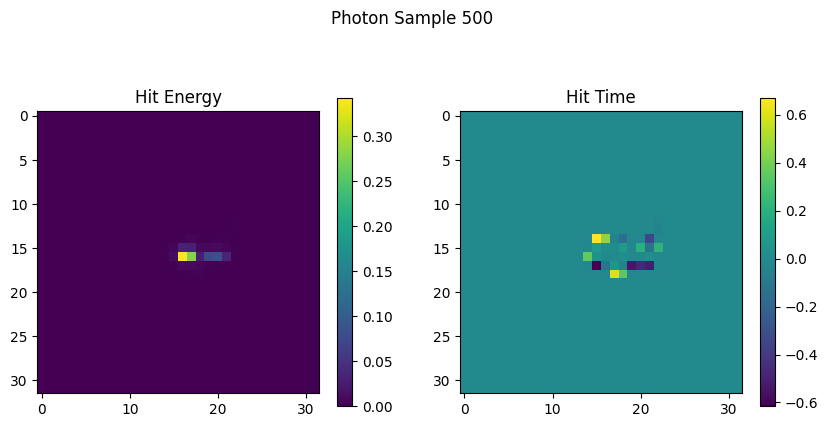

In [ ]:
import matplotlib.pyplot as plt

electron_X_np = np.array(electron_X)
photon_X_np = np.array(photon_X)

def display_statistics(data):
    energy_data = data[:, :, :, 0]
    time_data = data[:, :, :, 1]
    
    print("Hit Energy Channel:")
    print(f"  Min: {energy_data.min()}")
    print(f"  Max: {energy_data.max()}")
    print(f"  Mean: {energy_data.mean()}")
    print(f"  Std: {energy_data.std()}")
    
    print("\nHit Time Channel:")
    print(f"  Min: {time_data.min()}")
    print(f"  Max: {time_data.max()}")
    print(f"  Mean: {time_data.mean()}")
    print(f"  Std: {time_data.std()}")

print("Electron data statistics:")
display_statistics(electron_X_np)
print("\nPhoton data statistics:")
display_statistics(photon_X_np)

print("Electron data statistics:")
display_statistics(electron_X_np)
print("\nPhoton data statistics:")
display_statistics(photon_X_np)

def plot_sample(sample, title):
    energy = sample[:, :, 0]
    time = sample[:, :, 1]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    im1 = axs[0].imshow(sample[:, :, 0], cmap='viridis')
    axs[0].imshow(energy, cmap='viridis')
    cbar1 = plt.colorbar(im1, ax=axs[0], shrink=0.8)
    axs[0].set_title('Hit Energy')
    im2 = axs[1].imshow(sample[:, :, 1], cmap='viridis')
    axs[1].imshow(time, cmap='viridis')
    cbar2 = plt.colorbar(im2, ax=axs[1], shrink=0.8)
    axs[1].set_title('Hit Time')
    plt.suptitle(title)
    plt.show()

# Visualize a few samples from electron and photon datasets
plot_sample(electron_X_np[100], 'Electron Sample 100')
plot_sample(electron_X_np[500], 'Electron Sample 500')
plot_sample(photon_X_np[100], 'Photon Sample 100')
plot_sample(photon_X_np[500], 'Photon Sample 500')


In [ ]:
# Combine electron and photon data and labels

X = np.concatenate((electron_X, photon_X), axis=0)
y = np.concatenate((electron_y, photon_y), axis=0)

In [ ]:
# Normalize the data
# Assuming X is a 4D array (samples, width, height, channels)

X_normalized = X / X.max(axis=(0, 1, 2), keepdims=True)

In [ ]:
# Apply quantization

n_bits = 8
X_quantized = np.round(X_normalized * (2**n_bits - 1)).astype(np.uint8)


In [ ]:
# Split the data into training and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_quantized, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Create stratified batches for training and validation data

from sklearn.model_selection import StratifiedShuffleSplit

batch_size = 8300  # Adjust this based on the desired batch size
sss = StratifiedShuffleSplit(n_splits=1, test_size=batch_size, random_state=42)

def create_stratified_batches(X_data, y_data, batch_size):
    n_splits = int(np.ceil(len(X_data) / batch_size))
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=batch_size, random_state=42)
    batches = []

    for train_index, test_index in sss.split(X_data, y_data):
        X_batch, y_batch = X_data[test_index], y_data[test_index]
        batches.append((X_batch, y_batch))
    
    return batches

train_batches = create_stratified_batches(X_train, y_train, batch_size)
val_batches = create_stratified_batches(X_val, y_val, batch_size)

In [ ]:
# Save stratified batches into Parquet files

import pickle

def save_batches(batches, prefix):
    for i, (batch_data, batch_labels) in enumerate(batches):
        # Save data and labels as binary data
        with open(f'{prefix}_batch_{i}_data.pkl', 'wb') as data_file:
            pickle.dump(batch_data, data_file)
        with open(f'{prefix}_batch_{i}_labels.pkl', 'wb') as labels_file:
            pickle.dump(batch_labels, labels_file)

save_batches(train_batches, '/content/drive/MyDrive/GSoC/task_1/prcsd_training/training')
save_batches(val_batches, '/content/drive/MyDrive/GSoC/task_1/prcsd_val/validation')


Batch      Electron   Photon    
0          4150       4150      
1          4150       4150      
2          4150       4150      
3          4150       4150      
4          4150       4150      
5          4150       4150      
6          4150       4150      
7          4150       4150      
8          4150       4150      
9          4150       4150      
Hit Energy Channel:
  Min: 0
  Max: 246
  Mean: 0.20384012612951807
  Std: 4.064403768854381

Hit Time Channel:
  Min: 0
  Max: 255
  Mean: 9.92738234186747
  Std: 47.70885034491328


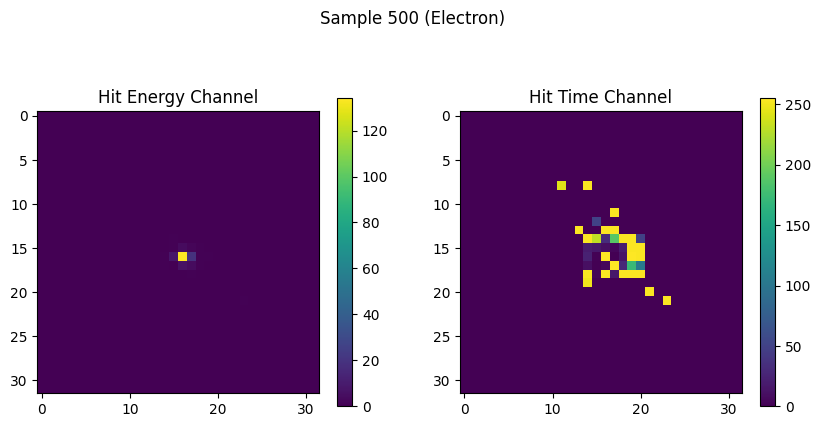

In [ ]:
import pickle
import matplotlib.pyplot as plt

def display_statistics(data):
    energy_data = data[:, :, :, 0]
    time_data = data[:, :, :, 1]
    
    print("Hit Energy Channel:")
    print(f"  Min: {energy_data.min()}")
    print(f"  Max: {energy_data.max()}")
    print(f"  Mean: {energy_data.mean()}")
    print(f"  Std: {energy_data.std()}")
    
    print("\nHit Time Channel:")
    print(f"  Min: {time_data.min()}")
    print(f"  Max: {time_data.max()}")
    print(f"  Mean: {time_data.mean()}")
    print(f"  Std: {time_data.std()}")

# Load data and labels from a .pkl file
def load_batch_data(prefix, batch_index):
    with open(f'{prefix}_batch_{batch_index}_data.pkl', 'rb') as data_file:
        batch_data = pickle.load(data_file)
    with open(f'{prefix}_batch_{batch_index}_labels.pkl', 'rb') as labels_file:
        batch_labels = pickle.load(labels_file)
    
    n_electron = sum(batch_labels == 1)
    n_photon = sum(batch_labels == 0)
    
    return batch_data, batch_labels, n_electron, n_photon

# Display label counts for each batch
prefix = '/content/drive/MyDrive/GSoC/task_1/prcsd_training/training'
n_batches = 10

print(f"{'Batch':<10} {'Electron':<10} {'Photon':<10}")
for i in range(n_batches):
    _, _, n_electron, n_photon = load_batch_data(prefix, i)
    print(f"{i:<10} {n_electron:<10} {n_photon:<10}")

# Load the first batch of training data
batch_data, batch_labels, _, _ = load_batch_data(prefix, 0)

# Display statistics
display_statistics(batch_data)

# Plot the data (first sample)
sample_index = 500
sample = batch_data[sample_index]
label = batch_labels[sample_index]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im1 = ax[0].imshow(sample[:, :, 0], cmap='viridis')
ax[0].set_title("Hit Energy Channel")
cbar1 = plt.colorbar(im1, ax=ax[0], shrink=0.8)
im2 = ax[1].imshow(sample[:, :, 1], cmap='viridis')
ax[1].set_title("Hit Time Channel")
cbar2 = plt.colorbar(im2, ax=ax[1], shrink=0.8)
plt.suptitle(f"Sample {sample_index} ({'Electron' if label == 1 else 'Photon'})")
plt.show()



In [ ]:
!pip install -q tensorflow
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.efficientnet import EfficientNetB2

# Create the hybrid model
def create_hybrid_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Reshape the input data to have 3 channels
    x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])
    
    # Residual block
    res_block = tf.keras.layers.Conv2D(6, (3, 3), activation='gelu', padding='same')(x)
    res_block = tf.keras.layers.BatchNormalization()(res_block)
    res_block = tf.keras.layers.DepthwiseConv2D((3, 3), activation='gelu', padding='same')(res_block)
    res_block = tf.keras.layers.BatchNormalization()(res_block)
    res_block = tf.keras.layers.add([x, res_block])
    
    # Reduce channels to 3 using a 1x1 convolution
    reduced_channels = tf.keras.layers.Conv2D(3, (1, 1), activation='gelu')(res_block)
    
    # EfficientNet
    efficientnet = EfficientNetB2(include_top=False, input_shape=(32, 32, 3), weights='imagenet')
    efficientnet.trainable = True
    
    x = efficientnet(reduced_channels)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='gelu', kernel_initializer='lecun_normal')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_normal')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (32, 32, 2)
model = create_hybrid_model(input_shape)
model.summary()

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


31790344/31790344 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 2)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 6)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 6)    330         ['concatenate[0][0]']            
                             

In [ ]:
from sklearn.metrics import roc_auc_score

class StopAtROCAUC(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(StopAtROCAUC, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        # Get the validation data from the generator
        val_data, val_labels = [], []
        for i in range(num_val_batches):
            X_val_batch, y_val_batch = load_batch_data(val_prefix, i)
            val_data.append(X_val_batch)
            val_labels.append(y_val_batch)

        X_val = np.concatenate(val_data, axis=0)
        y_val = np.concatenate(val_labels, axis=0)

        # Compute the ROC-AUC score
        y_pred = self.model.predict(X_val)
        roc_auc = roc_auc_score(y_val, y_pred)

        print(f"\nROC-AUC score for epoch {epoch + 1}: {roc_auc:.4f}")

        # Check if the ROC-AUC score has reached the threshold
        if roc_auc >= self.threshold:
            print(f"\nReached {self.threshold * 100:.2f}% ROC-AUC score. Stopping training.")
            self.model.stop_training = True

In [ ]:
import os
import numpy as np
import pickle
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.metrics import AUC

# Initialize LabelBinarizer
label_binarizer = LabelBinarizer()
label_binarizer.fit([0, 1])

# Load data and labels from pkl files
def load_batch_data(prefix, batch_index):
    with open(f'{prefix}_batch_{batch_index}_data.pkl', 'rb') as data_file:
        batch_data = pickle.load(data_file)
    with open(f'{prefix}_batch_{batch_index}_labels.pkl', 'rb') as labels_file:
        batch_labels = pickle.load(labels_file)
    
    # Transform labels into one-hot encoded format
    batch_labels = label_binarizer.transform(batch_labels)
    
    return batch_data, batch_labels

# Data generator
def data_generator(prefix, num_batches):
    while True:
        for i in range(num_batches):
            X, y = load_batch_data(prefix, i)
            yield X, y

# Set parameters
train_prefix = '/content/drive/MyDrive/GSoC/task_1/prcsd_training/training'
val_prefix = '/content/drive/MyDrive/GSoC/task_1/prcsd_val/validation'
num_train_batches = 48  # Adjust this based on the number of training batches you have
num_val_batches = 12  # Adjust this based on the number of validation batches you have
batch_size = 8300

# Create data generators
train_generator = data_generator(train_prefix, num_train_batches)
val_generator = data_generator(val_prefix, num_val_batches)

# Compile the model
rmsprop_optimizer = RMSprop(learning_rate=1e-4)
loss = 'binary_crossentropy'
metrics = [AUC(name='auc'), 'accuracy']

model.compile(optimizer=rmsprop_optimizer, loss=loss, metrics=metrics)

# Set the ROC-AUC threshold to 0.8
stop_at_roc_auc = StopAtROCAUC(threshold=0.8)

# Train the model
epochs = 50
steps_per_epoch = num_train_batches
validation_steps = num_val_batches

history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[stop_at_roc_auc])


Epoch 1/50
3113/3113 [==============================] - 31s 9ms/step

ROC-AUC score for epoch 1: 0.4657
48/48 [==============================] - 132s 1s/step - loss: 0.7089 - auc: 0.5283 - accuracy: 0.5202 - val_loss: 0.6948 - val_auc: 0.4663 - val_accuracy: 0.4752
Epoch 2/50
3113/3113 [==============================] - 29s 9ms/step

ROC-AUC score for epoch 2: 0.5016
48/48 [==============================] - 60s 1s/step - loss: 0.6945 - auc: 0.5589 - accuracy: 0.5422 - val_loss: 0.6934 - val_auc: 0.5025 - val_accuracy: 0.5011
Epoch 3/50
3113/3113 [==============================] - 29s 9ms/step

ROC-AUC score for epoch 3: 0.5653
48/48 [==============================] - 60s 1s/step - loss: 0.6880 - auc: 0.5738 - accuracy: 0.5534 - val_loss: 0.6890 - val_auc: 0.5651 - val_accuracy: 0.5269
Epoch 4/50
3113/3113 [==============================] - 29s 9ms/step

ROC-AUC score for epoch 4: 0.5593
48/48 [==============================] - 60s 1s/step - loss: 0.6839 - auc: 0.5836 - accuracy: 0.5601

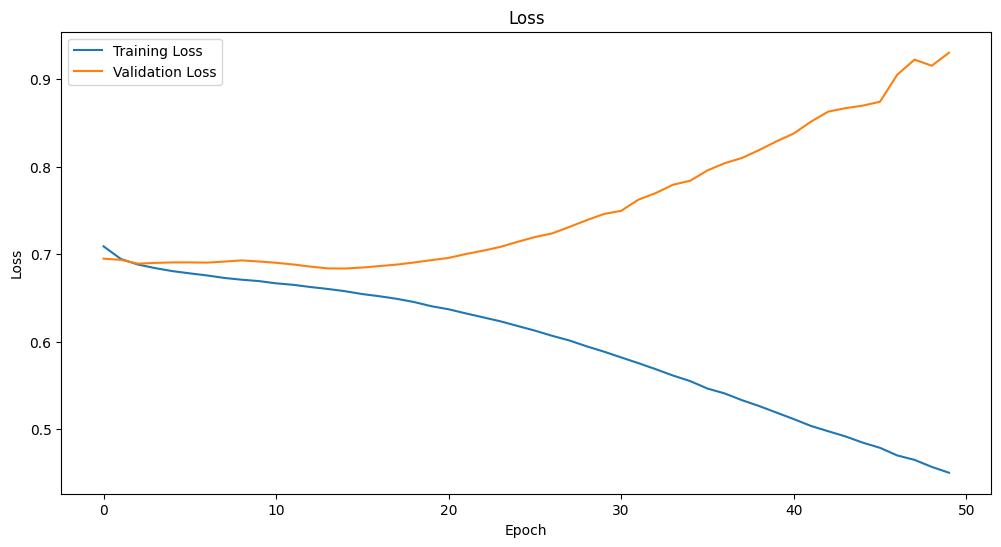

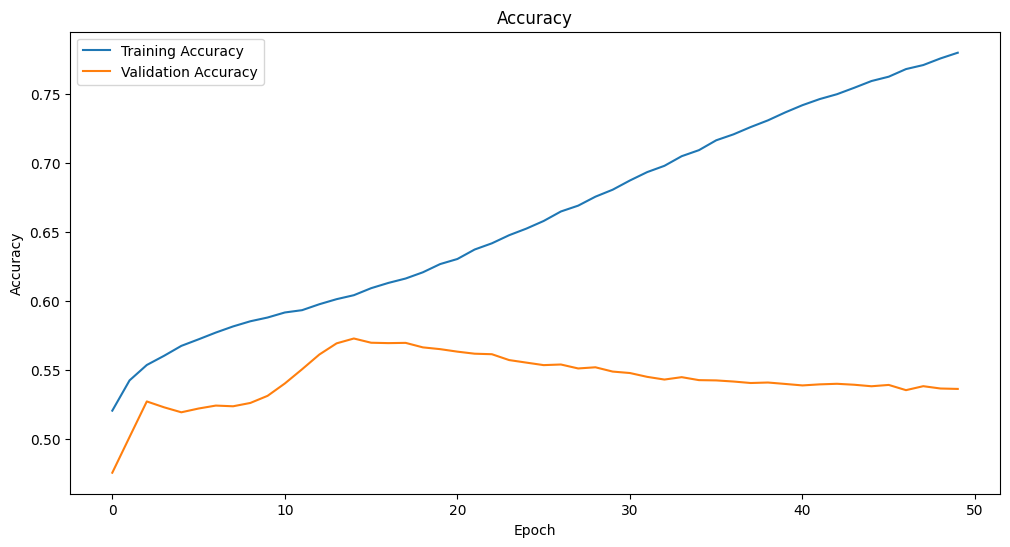

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3113/3113 [==============================] - 28s 9ms/step


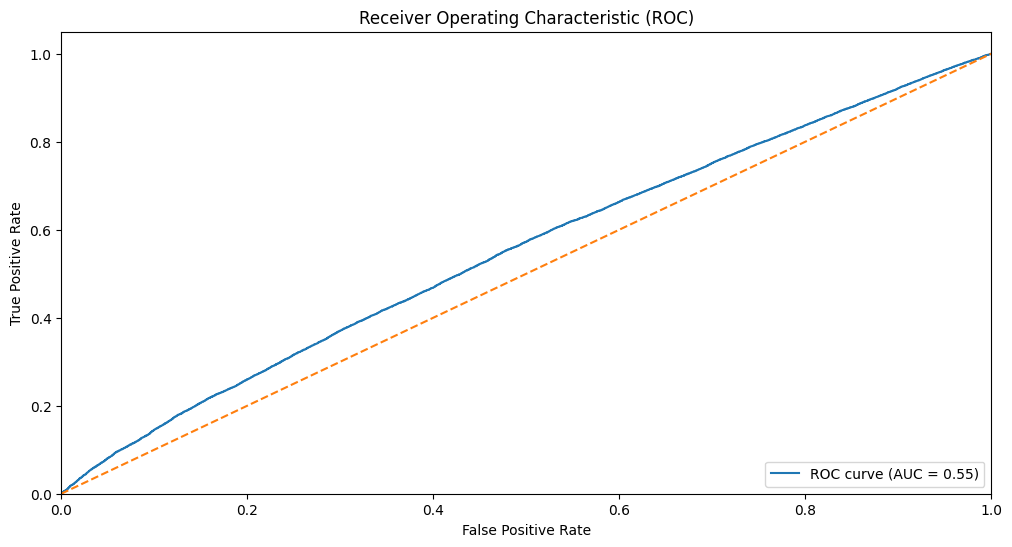

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Concatenate validation data
X_val = []
y_val = []

for i in range(num_val_batches):
    X_batch, y_batch = load_batch_data(val_prefix, i)
    X_val.append(X_batch)
    y_val.append(y_batch)

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

# Get the predicted probabilities for the positive class (class 1)
y_pred_probs = model.predict(X_val)[:, 0]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/GSoC/task_1/model/model_frozen_efficientnet_weights.h5')

In [ ]:
from tensorflow.keras import backend as K

# Clear GPU memory
K.clear_session()

In [ ]:
!pip install -q tensorflow
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.efficientnet import EfficientNetB2

# Create the hybrid model
def create_hybrid_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Reshape the input data to have 3 channels
    x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])
    
    # Residual block
    res_block = tf.keras.layers.Conv2D(6, (3, 3), activation='gelu', padding='same')(x)
    res_block = tf.keras.layers.BatchNormalization()(res_block)
    res_block = tf.keras.layers.DepthwiseConv2D((3, 3), activation='gelu', padding='same')(res_block)
    res_block = tf.keras.layers.BatchNormalization()(res_block)
    res_block = tf.keras.layers.add([x, res_block])
    
    # Reduce channels to 3 using a 1x1 convolution
    reduced_channels = tf.keras.layers.Conv2D(3, (1, 1), activation='gelu')(res_block)
    
    # EfficientNet
    efficientnet = EfficientNetB2(include_top=False, input_shape=(32, 32, 3), weights='imagenet')
    efficientnet.trainable = True
    
    x = efficientnet(reduced_channels)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='gelu', kernel_initializer='lecun_normal')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_normal')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
input_shape = (32, 32, 2)
loaded_model = create_hybrid_model(input_shape)
loaded_model.load_weights('/content/drive/MyDrive/GSoC/task_1/model/model_frozen_efficientnet_weights.h5')
loaded_model.summary()

31790344/31790344 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 2)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 6)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 6)    330         ['concatenate[0][0]']            
                             

In [ ]:
from sklearn.metrics import roc_auc_score

class StopAtROCAUC(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(StopAtROCAUC, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        # Get the validation data from the generator
        val_data, val_labels = [], []
        for i in range(num_val_batches):
            X_val_batch, y_val_batch = load_batch_data(val_prefix, i)
            val_data.append(X_val_batch)
            val_labels.append(y_val_batch)

        X_val = np.concatenate(val_data, axis=0)
        y_val = np.concatenate(val_labels, axis=0)

        # Compute the ROC-AUC score
        y_pred = self.model.predict(X_val)
        roc_auc = roc_auc_score(y_val, y_pred)

        print(f"\nROC-AUC score for epoch {epoch + 1}: {roc_auc:.4f}")

        # Check if the ROC-AUC score has reached the threshold
        if roc_auc >= self.threshold:
            print(f"\nReached {self.threshold * 100:.2f}% ROC-AUC score. Stopping training.")
            self.model.stop_training = True

In [ ]:
import os
import numpy as np
import pickle
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers.schedules import CosineDecay

# Initialize LabelBinarizer
label_binarizer = LabelBinarizer()
label_binarizer.fit([0, 1])

# Load data and labels from pkl files
def load_batch_data(prefix, batch_index):
    with open(f'{prefix}_batch_{batch_index}_data.pkl', 'rb') as data_file:
        batch_data = pickle.load(data_file)
    with open(f'{prefix}_batch_{batch_index}_labels.pkl', 'rb') as labels_file:
        batch_labels = pickle.load(labels_file)
    
    # Transform labels into one-hot encoded format
    batch_labels = label_binarizer.transform(batch_labels)
    
    return batch_data, batch_labels

# Data generator
def data_generator(prefix, num_batches):
    while True:
        for i in range(num_batches):
            X, y = load_batch_data(prefix, i)
            yield X, y

# Set parameters
train_prefix = '/content/drive/MyDrive/GSoC/task_1/prcsd_training/training'
val_prefix = '/content/drive/MyDrive/GSoC/task_1/prcsd_val/validation'
num_train_batches = 48  # Adjust this based on the number of training batches
num_val_batches = 12  # Adjust this based on the number of validation batches
batch_size = 8300

# Create data generators
train_generator = data_generator(train_prefix, num_train_batches)
val_generator = data_generator(val_prefix, num_val_batches)


# Set up the cosine annealing schedule for fine-tuning
fine_tuning_epochs = 50
steps_per_epoch = num_train_batches
validation_steps = num_val_batches
initial_learning_rate = 1e-4  # Set learning rate for fine-tuning
total_steps = fine_tuning_epochs * steps_per_epoch
cosine_decay = CosineDecay(initial_learning_rate, total_steps)

# Set the ROC-AUC threshold to 0.8
stop_at_roc_auc = StopAtROCAUC(threshold=0.8)

# Compile the loaded model with CosineDecay
rmsprop_optimizer = RMSprop(learning_rate=cosine_decay)
loss = 'binary_crossentropy'
metrics = [AUC(name='auc'), 'accuracy']

loaded_model.compile(optimizer=rmsprop_optimizer, loss=loss, metrics=metrics)

# Train the loaded model with CosineDecay
fine_tuning_history = loaded_model.fit(train_generator,
                                       epochs=fine_tuning_epochs,
                                       steps_per_epoch=steps_per_epoch,
                                       validation_data=val_generator,
                                       validation_steps=validation_steps,
                                       verbose=1,
                                       callbacks=[stop_at_roc_auc])

Epoch 1/50
3113/3113 [==============================] - 37s 11ms/step

ROC-AUC score for epoch 1: 0.5499
48/48 [==============================] - 182s 2s/step - loss: 0.4464 - auc: 0.8711 - accuracy: 0.7816 - val_loss: 0.9434 - val_auc: 0.5497 - val_accuracy: 0.5334
Epoch 2/50
3113/3113 [==============================] - 35s 11ms/step

ROC-AUC score for epoch 2: 0.5490
48/48 [==============================] - 66s 1s/step - loss: 0.4374 - auc: 0.8769 - accuracy: 0.7876 - val_loss: 0.9579 - val_auc: 0.5490 - val_accuracy: 0.5352
Epoch 3/50
3113/3113 [==============================] - 35s 11ms/step

ROC-AUC score for epoch 3: 0.5525
48/48 [==============================] - 66s 1s/step - loss: 0.4310 - auc: 0.8809 - accuracy: 0.7912 - val_loss: 0.9604 - val_auc: 0.5525 - val_accuracy: 0.5373
Epoch 4/50
3113/3113 [==============================] - 34s 11ms/step

ROC-AUC score for epoch 4: 0.5482
48/48 [==============================] - 66s 1s/step - loss: 0.4262 - auc: 0.8837 - accuracy: 0.

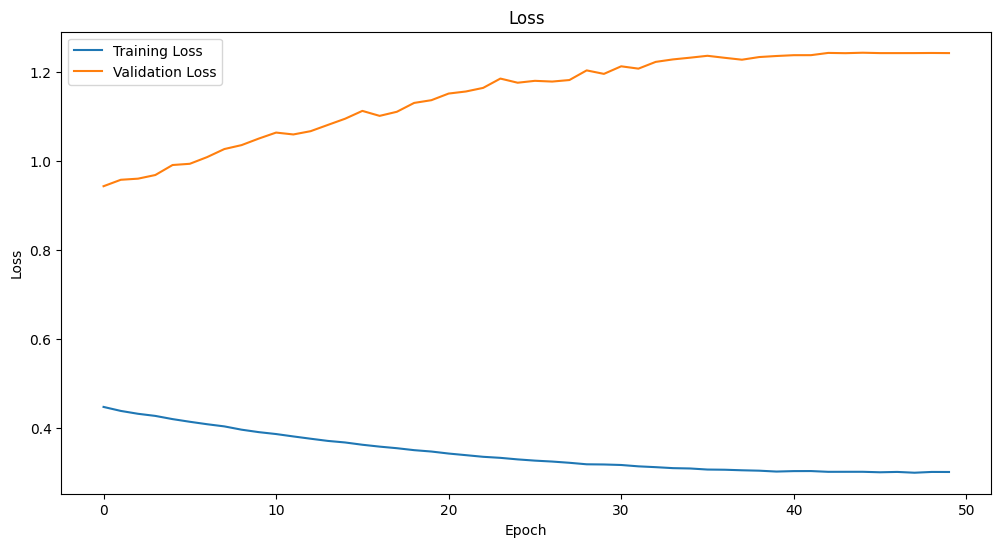

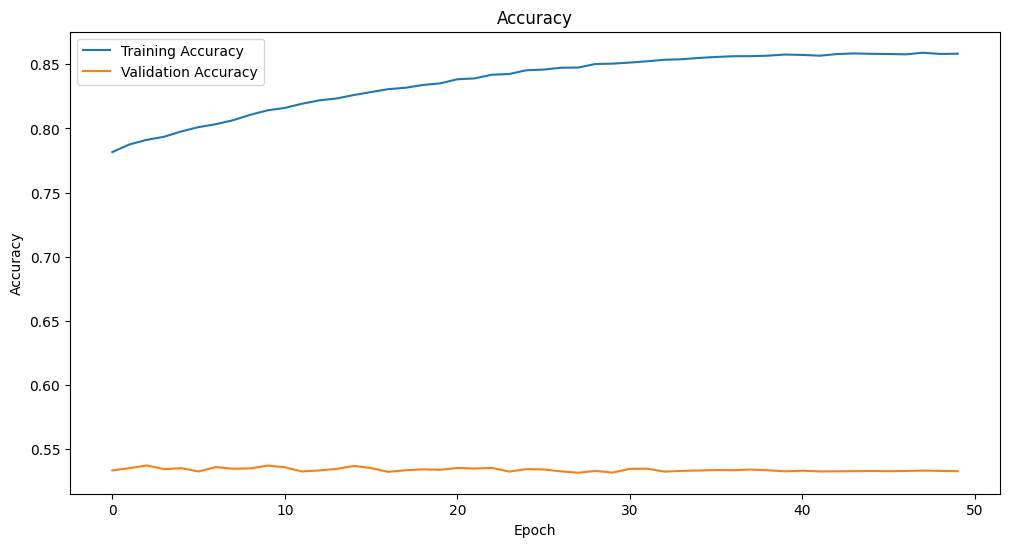

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(fine_tuning_history.history['loss'], label='Training Loss')
plt.plot(fine_tuning_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(fine_tuning_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tuning_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3113/3113 [==============================] - 33s 11ms/step


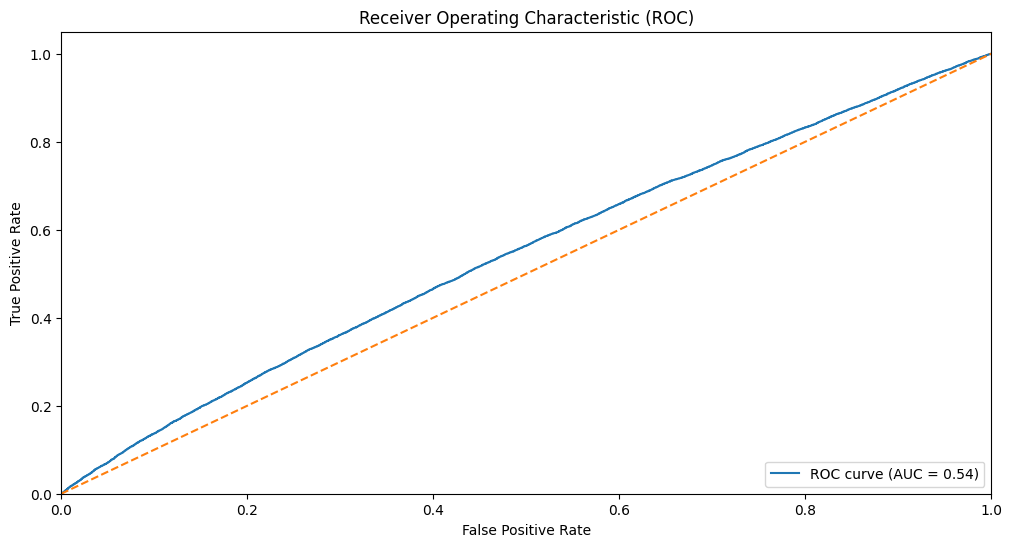

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Concatenate validation data
X_val = []
y_val = []

for i in range(num_val_batches):
    X_batch, y_batch = load_batch_data(val_prefix, i)
    X_val.append(X_batch)
    y_val.append(y_batch)

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

# Get the predicted probabilities for the positive class (class 1)
y_pred_probs = loaded_model.predict(X_val)[:, 0]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the fine-tuned model
loaded_model.save_weights('/content/drive/MyDrive/GSoC/task_1/model/model_fine_tuned_weights.h5')